In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from gensim.models.fasttext import FastText
from gensim.models.fasttext import load_facebook_model
import nltk
from nltk.cluster import KMeansClusterer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [3]:
df = pd.read_csv('AllBooks_baseline_DTM_Labelled.csv')
df.rename(columns={'Unnamed: 0': 'Books'}, inplace=True)
df.head()

,Books,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
0,Buddhism_Ch1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Buddhism_Ch2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Buddhism_Ch3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Buddhism_Ch4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Buddhism_Ch5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
words = np.array(df.columns[1:])
word_count = pd.DataFrame(df.sum()[1:], columns=['Count'])

In [5]:
words_clean = []
for w in words:
    if len(w) > 2 and len(w) < 15:
        words_clean.append(w)
words_clean = np.array(words_clean)
df_clean = df[words_clean]

df_clean.drop(columns=words_clean[np.where(df_clean.sum().values < 5)], inplace=True)
df_clean['Books'] = df['Books'].values
df = df_clean
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

words = np.array(df.columns[1:])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-5-816d8997bfff>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Books'] = df['Books'].values


In [6]:
df.head()

,Books,hath,feelings,anger,open,rage,looketh,illumination,tell,build,...,glad,needs,well,state,production,developed,regarded,taketh,thoughts,illumines
0,Buddhism_Ch1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Buddhism_Ch2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Buddhism_Ch3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Buddhism_Ch4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2,0,0,0,0
4,Buddhism_Ch5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
buddhism = df[df['Books'].str.contains('Buddhism')]
buddhism = pd.DataFrame(buddhism.sum()[1:], columns=['Count'])

taoteching = df[df['Books'].str.contains('TaoTeChing')]
taoteching = pd.DataFrame(taoteching.sum()[1:], columns=['Count'])

upanishad = df[df['Books'].str.contains('Upanishad')]
upanishad = pd.DataFrame(upanishad.sum()[1:], columns=['Count'])

yogasutra = df[df['Books'].str.contains('YogaSutra')]
yogasutra = pd.DataFrame(yogasutra.sum()[1:], columns=['Count'])

proverb = df[df['Books'].str.contains('Proverb')]
proverb = pd.DataFrame(proverb.sum()[1:], columns=['Count'])

eccleasiasticus = df[df['Books'].str.contains('Eccleasiasticus')]
eccleasiasticus = pd.DataFrame(eccleasiasticus.sum()[1:], columns=['Count'])

wisdom = df[df['Books'].str.contains('Wisdom')]
wisdom = pd.DataFrame(wisdom.sum()[1:], columns=['Count'])

words = np.array(df.columns[1:])

In [8]:
eastern = pd.concat([buddhism.T, taoteching.T])
eastern.index = ['Buddhism', 'Tao']
eastern = eastern.drop(columns=words[np.where(eastern.sum() == 0)])
eastern

,feelings,anger,open,rage,illumination,tell,neither,soft,mentally,land,...,business,red,grows,needs,well,state,production,developed,regarded,thoughts
Buddhism,19,0,2,0,1,14,15,0,5,4,...,0,3,3,0,5,0,4,10,0,9
Tao,0,1,2,1,0,1,1,7,0,2,...,1,0,0,2,3,28,1,0,3,0


In [9]:
eastern_words = np.array(eastern.columns)
eastern_words

array(['feelings', 'anger', 'open', ..., 'developed', 'regarded',
       'thoughts'], dtype=object)

In [10]:
# Creating pretrained fasttext model from Crawl EN
fb_model = load_facebook_model('crawl-300d-2M-subword.bin')

In [11]:
fb_model.build_vocab(eastern_words, update = True)
fb_model.train(eastern_words, total_examples = fb_model.corpus_count, epochs = 100)

(22232, 812400)

In [12]:
print(fb_model.wv.similarity('soul', 'mind'))

0.5782816


In [13]:
X = fb_model.wv[eastern_words]

In [14]:
X.shape

(1279, 300)

In [15]:
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors, data):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(16, 16))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[np.array(colors).astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.
        x_temp = data[data['Y'] == i]
        xtext = np.median(x_temp['pca1'])
        ytext = np.median(x_temp['pca2'])
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [300]:
NUM_CLUSTERS = 9
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance = nltk.cluster.util.cosine_distance, repeats = 25)
Y = kclusterer.cluster(X, assign_clusters = True)

In [301]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(X)

In [302]:
pca_tsne = TSNE(random_state = RS).fit_transform(pca_result_50)

In [303]:
tsne_df = pd.DataFrame(columns = ['pca1','pca2'])
tsne_df['pca1'] = pca_tsne[:,0]
tsne_df['pca2'] = pca_tsne[:,1]

In [304]:
tsne_labelled = tsne_df.copy()
tsne_labelled['Y'] = Y

(<Figure size 1152x1152 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-23.538057, -22.648022, '0'),
  Text(0.5663059, -20.755497, '1'),
  Text(23.645163, 24.58831, '2'),
  Text(-27.93565, -2.1824245, '3'),
  Text(-17.315462, 8.744926, '4'),
  Text(-7.355224, 8.059377, '5'),
  Text(-1.5707259, 10.055416, '6'),
  Text(18.67114, 4.4432774, '7'),
  Text(18.08054, -11.8905115, '8')])

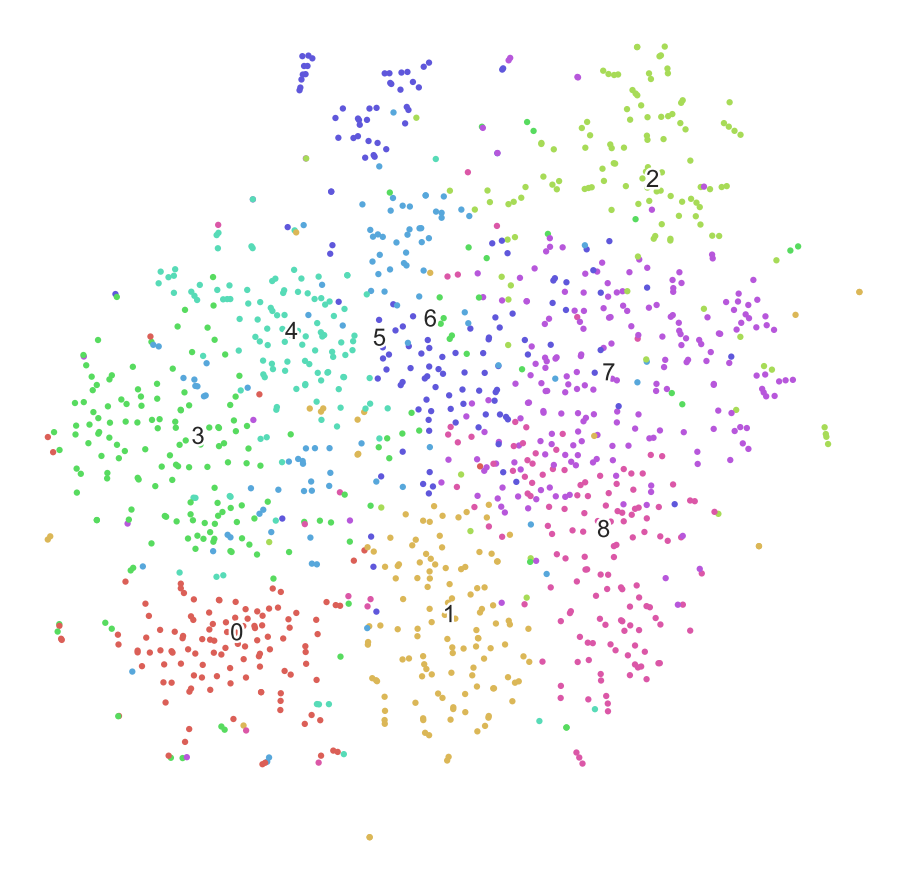

In [305]:
fashion_scatter(tsne_df.values, Y, tsne_labelled)

In [137]:
tsne_final = tsne_labelled.copy()
tsne_final['Word'] = eastern_words
tsne_final.rename(columns={'pca1': 'x', 'pca2': 'y', 'Y': 'Category'}, inplace=True)

bud_t = buddhism.T
buddhist_words = np.array(bud_t.columns)
buddhist_words = np.array(bud_t.drop(columns=buddhist_words[np.where(bud_t.sum()==0)]).columns)
tao_t = taoteching.T
tao_words = np.array(tao_t.columns)
tao_words = np.array(tao_t.drop(columns=tao_words[np.where(tao_t.sum()==0)]).columns)

books = []
for i in range(len(eastern_words)):
    if eastern_words[i] in buddhist_words and eastern_words[i] in tao_words:
        books.append('Both')
    elif eastern_words[i] in buddhist_words:
        books.append('Buddhist')
    elif eastern_words[i] in tao_words:
        books.append('Tao')
tsne_final['Book'] = books

In [311]:
concept = pd.read_csv('chai.csv')

In [312]:
concept

,Unnamed: 0,x,y,Category,Word,Book
0,0,-18.182987,-21.067402,7,feelings,Buddhist
1,1,23.062016,-26.539265,7,anger,Tao
2,2,-6.889199,2.987535,4,open,Both
3,3,23.199852,-26.584093,7,rage,Tao
4,4,1.920885,-13.001882,9,illumination,Buddhist
...,...,...,...,...,...,...
1274,1274,-8.441429,-11.421192,8,state,Tao
1275,1275,-6.095231,-9.274641,8,production,Both
1276,1276,-2.047643,30.918629,0,developed,Buddhist
1277,1277,-0.478214,29.996874,0,regarded,Tao
